# Fraud Detection
### By Keith D. Smith
### Data:  https://www.kaggle.com/datasets/kornilovag94/payment-systems-transactions-synthetic-dataset

This particular project presented a challenge as the dataset was highly imbalenced.  This is an instance of event detection where the event is high impact but low frequency.

## Import Packages and Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import classification_report
from tabulate import tabulate

C:\Users\ksmith\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
df = pd.read_csv("fraud.csv", na_values=['NULL', '?', 'NONE'])

## EDA

In [3]:
df.shape

(6362620, 11)

In [4]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [6]:
mapping = {0: 'Valid', 1: 'Fraudulent'}
df['Fraud'] = df['isFraud'].map(mapping)

In [7]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Fraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,Valid
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,Valid
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,Fraudulent
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,Fraudulent
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,Valid


In [8]:
df.select_dtypes(exclude=['object']).describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [9]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

As is seen, there are over six million obsesrvations that were not fraudulent but just 8,213 observations that were fraudulent.  This is important because a model could prediction non-fradulent transactions for all observations and be extremely accurate.  Therefore, it is important to resample the data and then rely on metrics that accurately classify fraudulent behavior as fraudulent - sensitivity.

In [10]:
df = df.drop('step', axis=1)

In [11]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Fraud
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,Valid
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,Valid
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,Fraudulent
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,Fraudulent
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,Valid


array([[<AxesSubplot:title={'center':'amount'}>,
        <AxesSubplot:title={'center':'oldbalanceOrg'}>],
       [<AxesSubplot:title={'center':'newbalanceOrig'}>,
        <AxesSubplot:title={'center':'oldbalanceDest'}>],
       [<AxesSubplot:title={'center':'newbalanceDest'}>, <AxesSubplot:>]],
      dtype=object)

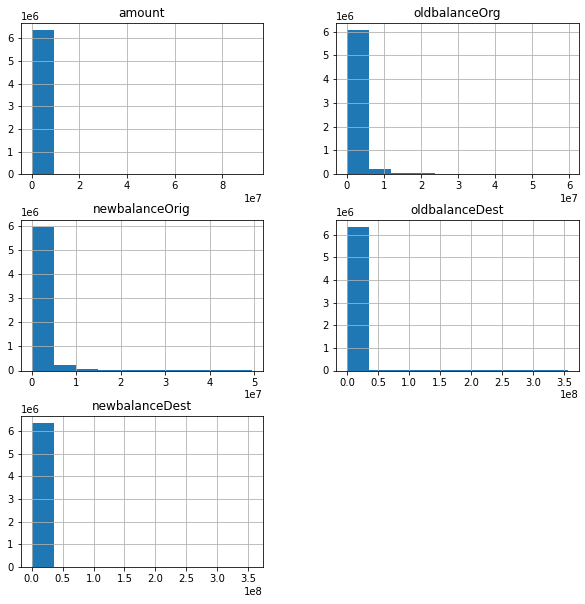

In [12]:
df.hist(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], figsize=(10, 10))

<BarContainer object of 2 artists>

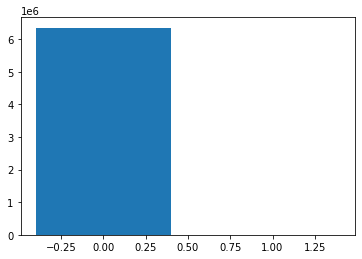

In [13]:
counts = df['isFraud'].value_counts()
plt.bar(counts.index, counts.values)

In [14]:
print(df.isnull().sum())

type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
Fraud             0
dtype: int64


<AxesSubplot:>

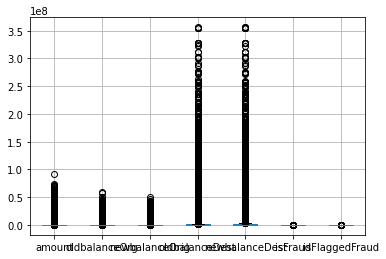

In [15]:
df.boxplot()

<ipython-input-16-ce189de096d9>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


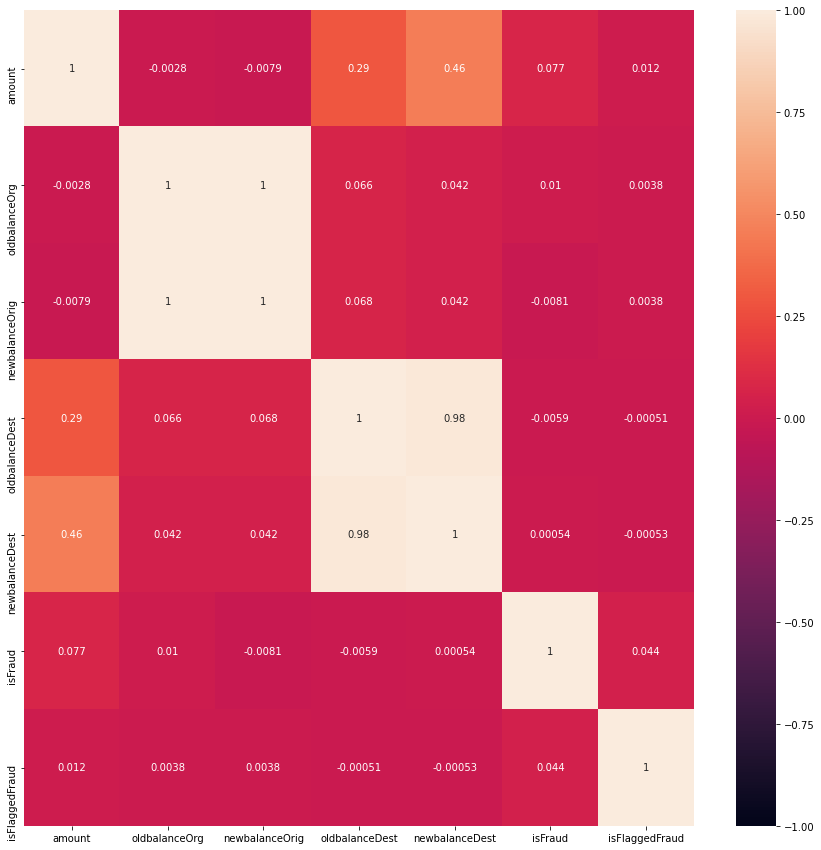

In [16]:
corr = df.corr()
plt.figure(figsize = (15, 15))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)

## Data Transformation

In [17]:
X = df.drop(['isFraud', 'Fraud'], axis=1)

In [18]:
y = df['isFraud']

In [19]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler(random_state = 42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

In [20]:
X = pd.get_dummies(X_resampled)

In [21]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

In [22]:
rfc.fit(X, y_resampled)

RandomForestClassifier(random_state=42)

In [23]:
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature Ranking")
for f in range(10):  # Iterate up to the top ten features
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

Feature Ranking
1. oldbalanceOrg (0.202092)
2. amount (0.139332)
3. newbalanceOrig (0.093322)
4. type_TRANSFER (0.093238)
5. type_PAYMENT (0.080500)
6. newbalanceDest (0.050750)
7. oldbalanceDest (0.044317)
8. type_CASH_IN (0.039311)
9. type_CASH_OUT (0.027714)
10. type_DEBIT (0.000919)


In [24]:
sum(importances)

0.9999999999999991

In [25]:
X = X_resampled[['oldbalanceOrg', 'amount', 'newbalanceOrig', 'newbalanceDest']]
y = y_resampled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Predictive Analysis

### KNN

In [26]:
knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn.fit(X_train, y_train.values.ravel())
y_pred_knn = knn.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred_knn)
tn, fp, fn, tp = cm.ravel()
sensitivity_knn = tp / (tp + fn)
cr = classification_report(y_test, y_pred_knn)
print("Confusion matrix:\n", cm)
print("Classification report:\n", cr)
print("Sensitivity:", sensitivity_knn)

Confusion matrix:
 [[1579   70]
 [  55 1582]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      1649
           1       0.96      0.97      0.96      1637

    accuracy                           0.96      3286
   macro avg       0.96      0.96      0.96      3286
weighted avg       0.96      0.96      0.96      3286

Sensitivity: 0.9664019547953574


### Naive Bayes

In [27]:
nb = GaussianNB()
nb.fit(X_train, y_train.values.ravel())
y_pred_nb = nb.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred_nb)
tn, fp, fn, tp = cm.ravel()
sensitivity_nb = tp / (tp + fn)
cr = classification_report(y_test, y_pred_nb)
print("Confusion matrix:\n", cm)
print("Classification report:\n", cr)
print("Sensitivity:", sensitivity_nb)

Confusion matrix:
 [[1599   50]
 [1049  588]]
Classification report:
               precision    recall  f1-score   support

           0       0.60      0.97      0.74      1649
           1       0.92      0.36      0.52      1637

    accuracy                           0.67      3286
   macro avg       0.76      0.66      0.63      3286
weighted avg       0.76      0.67      0.63      3286

Sensitivity: 0.3591936469150886


### Decision Tree

In [28]:
dtree = DecisionTreeClassifier(criterion='entropy',random_state = 42)
dtree.fit(X_train,y_train)
y_pred_dt = nb.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred_dt)
tn, fp, fn, tp = cm.ravel()
sensitivity_dt = tp / (tp + fn)
cr = classification_report(y_test, y_pred_dt)
print("Confusion matrix:\n", cm)
print("Classification report:\n", cr)
print("Sensitivity:", sensitivity_dt)

Confusion matrix:
 [[1599   50]
 [1049  588]]
Classification report:
               precision    recall  f1-score   support

           0       0.60      0.97      0.74      1649
           1       0.92      0.36      0.52      1637

    accuracy                           0.67      3286
   macro avg       0.76      0.66      0.63      3286
weighted avg       0.76      0.67      0.63      3286

Sensitivity: 0.3591936469150886


### Random Forrest

In [29]:
rfc_mod = RandomForestClassifier(n_estimators=10, random_state = 42)
rfc_mod.fit(X_train, y_train.values.ravel())
y_pred_rfc = rfc_mod.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred_rfc)
tn, fp, fn, tp = cm.ravel()
sensitivity_rfc = tp / (tp + fn)
cr = classification_report(y_test, y_pred_rfc)
print("Confusion matrix:\n", cm)
print("Classification report:\n", cr)
print("Sensitivity:", sensitivity_rfc)

Confusion matrix:
 [[1628   21]
 [   6 1631]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1649
           1       0.99      1.00      0.99      1637

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286

Sensitivity: 0.996334758704948


### XG Boost

In [30]:
xg= xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr',use_label_encoder=False, random_state = 42)
xg.fit(X_train, y_train.values.ravel())
y_pred_xg = xg.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred_xg)
tn, fp, fn, tp = cm.ravel()
sensitivity_xg = tp / (tp + fn)
cr = classification_report(y_test, y_pred_xg)
print("Confusion matrix:\n", cm)
print("Classification report:\n", cr)
print("Sensitivity:", sensitivity_xg)

C:\Users\ksmith\Anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Confusion matrix:
 [[1629   20]
 [   5 1632]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1649
           1       0.99      1.00      0.99      1637

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286

Sensitivity: 0.9969456322541234


### Model Comparison

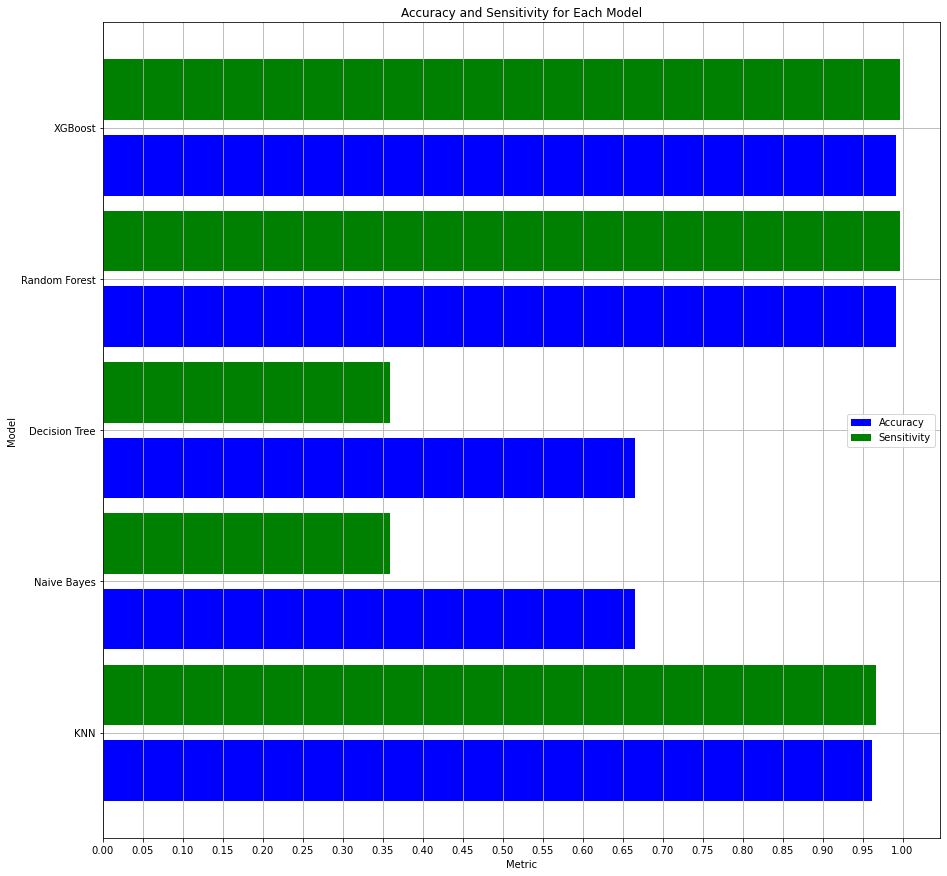

In [31]:
KNN_Accuracy = sum(y_pred_knn == y_test) / len(y_test)
Naive_Bayes_Accuracy = sum(y_pred_nb == y_test) / len(y_test)
Decision_Tree_Accuracy = sum(y_pred_dt == y_test) / len(y_test)
Random_Forest_Accuracy = sum(y_pred_rfc == y_test) / len(y_test)
XGBoost_Accuracy = sum(y_pred_xg == y_test) / len(y_test)

accuracies = [KNN_Accuracy, Naive_Bayes_Accuracy, Decision_Tree_Accuracy,Random_Forest_Accuracy, XGBoost_Accuracy]
sensitivities = [sensitivity_knn, sensitivity_nb, sensitivity_dt, sensitivity_rfc,sensitivity_xg]
model_names = ['KNN', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'XGBoost']

bar_width = 0.4
space = 0.1
bar_positions = np.arange(len(model_names))
fig, ax = plt.subplots(figsize=(15, 15))
ax.barh(bar_positions, accuracies, label='Accuracy', color='blue',height=bar_width)
ax.barh(bar_positions + bar_width + space, sensitivities, label='Sensitivity', color='green', height=bar_width)
ax.set_xlabel('Metric')
ax.set_ylabel('Model')
ax.set_title('Accuracy and Sensitivity for Each Model')
ax.set_yticks(bar_positions + bar_width / 2 + space / 2)
ax.set_yticklabels(model_names)
ax.set_xticks(np.arange(0, 1.05, 0.05))
ax.legend()
ax.grid(True)
plt.show()